In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'NOK=X'
numbers_in_currency = 'NOK'
share_name = 'BONHR.OL'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-12-31,3440,0,3440,273,5673,0,995,9250,0,...,0,0,1148,7409,17602,33485,1202,-1219,32.3,2015-02-14
1,2015-03-31,3707,0,3707,614,5501,0,1152,9374,0,...,0,0,1995,8551,17531,35532,-2032,5736,32.3,2015-05-05
2,2015-06-30,3918,0,3918,-2390,8952,0,1111,12987,0,...,0,0,3370,10468,17300,35884,1789,-1271,32.3,2015-07-15
3,2015-09-30,3402,0,3402,70,8637,0,1172,12278,0,...,0,0,3533,10838,17820,37295,1110,-1303,32.3,2015-10-25
4,2015-12-31,3602,0,3602,-1098,8340,0,1180,13586,0,...,0,0,3431,6984,17581,32705,1264,-1119,32.3,2016-02-14


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
35,2023-09-30,2023-10-25,42.50,3197,0,3197,172,5998,0,408,...,1186,23462,0,0,2413,5889,8202,16905,348,-248
36,2023-12-31,2024-02-14,42.50,3531,0,3531,287,5460,0,549,...,1223,23476,0,0,2363,5997,7717,16799,1,-294
37,2024-03-31,2024-04-29,42.53,2973,0,2973,304,6545,2839,556,...,1261,24581,0,0,2209,6166,8275,16377,1337,-342
38,2024-06-30,2024-07-08,42.53,4283,0,4283,694,6802,2715,392,...,1255,24222,0,0,2167,6164,7662,15759,1313,-243
39,2024-09-30,2024-10-21,42.53,3606,0,3606,350,6169,2904,350,...,1248,24596,0,0,1512,5691,7893,15622,724,-596


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-09-30,2023-10-25,42.50,3197,0,3197,172,5998,0,408,...,23462,0,0,2413,5889,8202,16905,348,-248,10.483742
36,2023-12-31,2024-02-14,42.50,3531,0,3531,287,5460,0,549,...,23476,0,0,2363,5997,7717,16799,1,-294,10.821103
37,2024-03-31,2024-04-29,42.53,2973,0,2973,304,6545,2839,556,...,24581,0,0,2209,6166,8275,16377,1337,-342,10.502364
38,2024-06-30,2024-07-08,42.53,4283,0,4283,694,6802,2715,392,...,24222,0,0,2167,6164,7662,15759,1313,-243,10.750878
39,2024-09-30,2024-10-21,42.53,3606,0,3606,350,6169,2904,350,...,24596,0,0,1512,5691,7893,15622,724,-596,10.704589


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-09-30,2023-10-25,42.50,3197,0,3197,172,5998,0,408,...,23462,0,0,2413,5889,8202,16905,348,-248,10.483742
36,2023-12-31,2024-02-14,42.50,3531,0,3531,287,5460,0,549,...,23476,0,0,2363,5997,7717,16799,1,-294,10.821103
37,2024-03-31,2024-04-29,42.53,2973,0,2973,304,6545,2839,556,...,24581,0,0,2209,6166,8275,16377,1337,-342,10.502364
38,2024-06-30,2024-07-08,42.53,4283,0,4283,694,6802,2715,392,...,24222,0,0,2167,6164,7662,15759,1313,-243,10.750878
39,2024-09-30,2024-10-21,42.53,3606,0,3606,350,6169,2904,350,...,24596,0,0,1512,5691,7893,15622,724,-596,10.704589


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)
filtered_nat_curr.head()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,usd_nat_currency,net_profit_ttm,cash_from_operating_activities_ttm,capex_ttm,revenue_ttm,cogs_ttm,eps,bv_per_share,fcf,fcf_per_share
0,2014-12-31,2015-02-14,32.3,3440,0,3440,273,5673,0,995,...,6.876861,NaN,NaN,NaN,NaN,None,NaN,245.541796,NaN,NaN
1,2015-03-31,2015-05-05,32.3,3707,0,3707,614,5501,0,1152,...,7.736785,NaN,NaN,NaN,NaN,None,NaN,265.448916,NaN,NaN
2,2015-06-30,2015-07-15,32.3,3918,0,3918,-2390,8952,0,1111,...,7.752235,NaN,NaN,NaN,NaN,None,NaN,272.879257,NaN,NaN
3,2015-09-30,2015-10-25,32.3,3402,0,3402,70,8637,0,1172,...,8.209375,-1433.0,2069.0,1943.0,14467.0,None,-44.365325,289.845201,126.0,3.900929
4,2015-12-31,2016-02-14,32.3,3602,0,3602,-1098,8340,0,1180,...,8.524693,-2804.0,2131.0,2043.0,14629.0,None,-86.811146,281.764706,88.0,2.724458


## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)
ratios_nat_curr.head()

,date,real_date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,total_liab,revenue_ttm,cogs_ttm
0,2014-12-31,2015-02-14,3440,NaN,245.541796,32.3,NaN,NaN,5673,33485,NaN,None
1,2015-03-31,2015-05-05,3707,NaN,265.448916,32.3,NaN,NaN,5501,35532,NaN,None
2,2015-06-30,2015-07-15,3918,NaN,272.879257,32.3,NaN,NaN,8952,35884,NaN,None
3,2015-09-30,2015-10-25,3402,-44.365325,289.845201,32.3,126.0,3.900929,8637,37295,14467.0,None
4,2015-12-31,2016-02-14,3602,-86.811146,281.764706,32.3,88.0,2.724458,8340,32705,14629.0,None


In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)
ratios_nat_curr.head()

,date,real_date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,total_liab,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-12-31,2015-02-14,3440,0.000000,245.541796,32.3,0.0,0.000000,5673,33485,...,0.191496,0.808504,0.0,0,0.000000,0,1.0,0.079360,0.000000,0.000000
1,2015-03-31,2015-05-05,3707,0.000000,265.448916,32.3,0.0,0.000000,5501,35532,...,0.194395,0.805605,0.0,0,0.000000,0,1.0,0.165633,0.000000,0.000000
2,2015-06-30,2015-07-15,3918,0.000000,272.879257,32.3,0.0,0.000000,8952,35884,...,0.197190,0.802810,0.0,0,0.000000,0,1.0,-0.610005,0.000000,0.000000
3,2015-09-30,2015-10-25,3402,-44.365325,289.845201,32.3,126.0,3.900929,8637,37295,...,0.200656,0.799344,0.0,0,1.675003,0,1.0,0.020576,-0.030714,-0.153066
4,2015-12-31,2016-02-14,3602,-86.811146,281.764706,32.3,88.0,2.724458,8340,32705,...,0.217696,0.782304,0.0,0,1.754077,0,1.0,-0.304831,-0.067072,-0.308098


# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2015-02-16,55.239021,2014-12-31,3440.0,0.0,245.541796,32.3,0.0,0.0,5673.0,...,0.191496,0.808504,0.0,0.0,0.0,0.0,1.0,0.07936,0.0,0.0
1,2015-02-23,52.082504,2014-12-31,3440.0,0.0,245.541796,32.3,0.0,0.0,5673.0,...,0.191496,0.808504,0.0,0.0,0.0,0.0,1.0,0.07936,0.0,0.0
2,2015-03-02,51.490658,2014-12-31,3440.0,0.0,245.541796,32.3,0.0,0.0,5673.0,...,0.191496,0.808504,0.0,0.0,0.0,0.0,1.0,0.07936,0.0,0.0
3,2015-03-09,49.320557,2014-12-31,3440.0,0.0,245.541796,32.3,0.0,0.0,5673.0,...,0.191496,0.808504,0.0,0.0,0.0,0.0,1.0,0.07936,0.0,0.0
4,2015-03-16,46.953175,2014-12-31,3440.0,0.0,245.541796,32.3,0.0,0.0,5673.0,...,0.191496,0.808504,0.0,0.0,0.0,0.0,1.0,0.07936,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2015-02-16,55.239021,2014-12-31,3440.0,0.0,245.541796,32.3,0.0,0.0,5673.0,...,0.0,1.0,0.07936,0.0,0.0,inf,0.224968,inf,inf,inf
1,2015-02-23,52.082504,2014-12-31,3440.0,0.0,245.541796,32.3,0.0,0.0,5673.0,...,0.0,1.0,0.07936,0.0,0.0,inf,0.212113,inf,inf,inf
2,2015-03-02,51.490658,2014-12-31,3440.0,0.0,245.541796,32.3,0.0,0.0,5673.0,...,0.0,1.0,0.07936,0.0,0.0,inf,0.209702,inf,inf,inf
3,2015-03-09,49.320557,2014-12-31,3440.0,0.0,245.541796,32.3,0.0,0.0,5673.0,...,0.0,1.0,0.07936,0.0,0.0,inf,0.200864,inf,inf,inf
4,2015-03-16,46.953175,2014-12-31,3440.0,0.0,245.541796,32.3,0.0,0.0,5673.0,...,0.0,1.0,0.07936,0.0,0.0,inf,0.191223,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

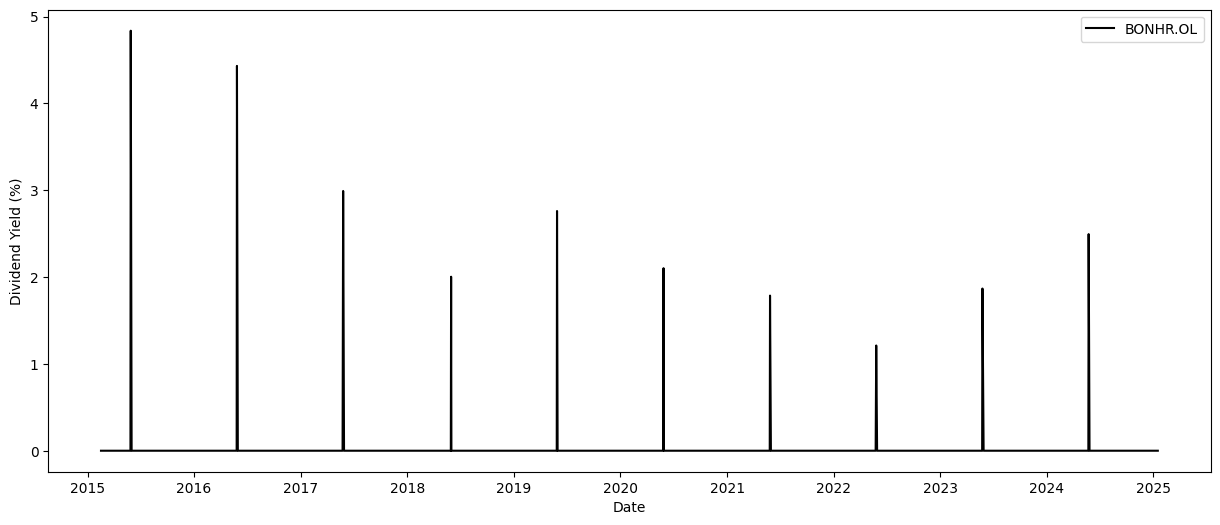

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.651156
share_price      1.000000
Name: share_price, dtype: float64


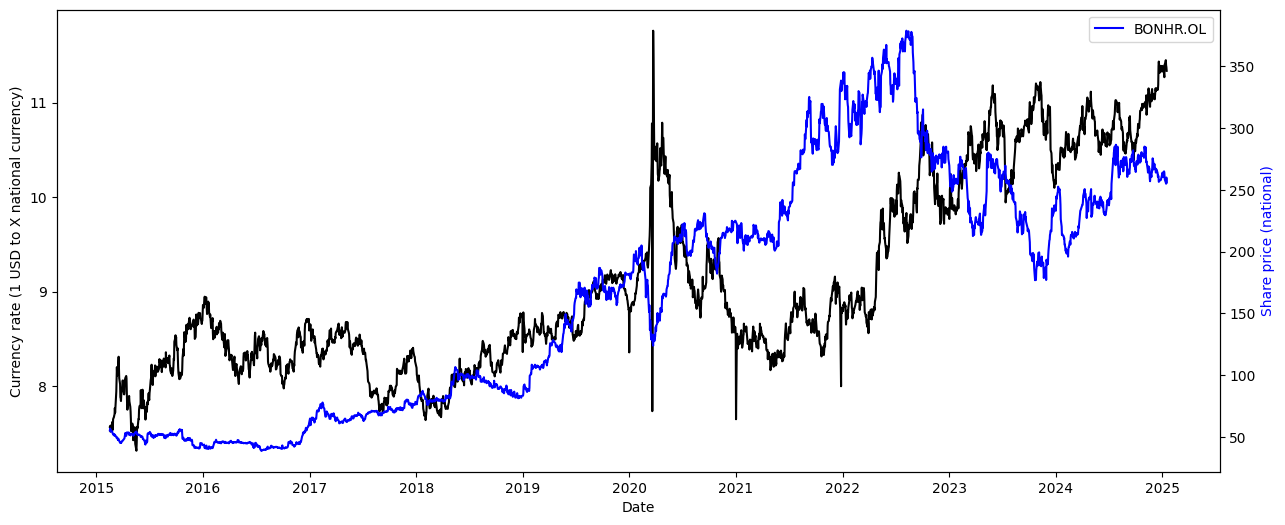

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

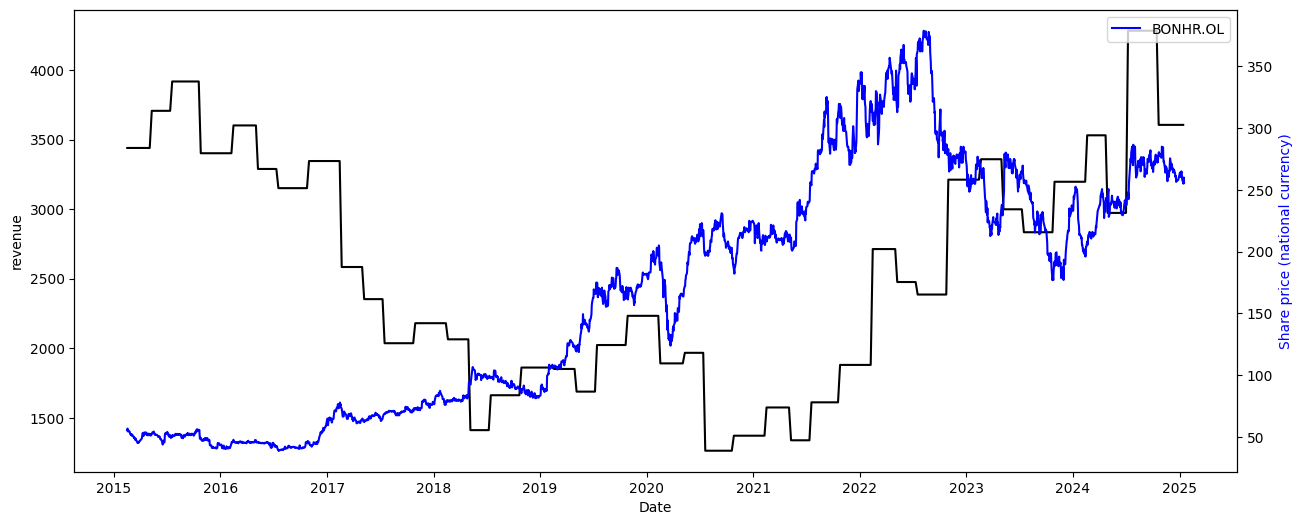

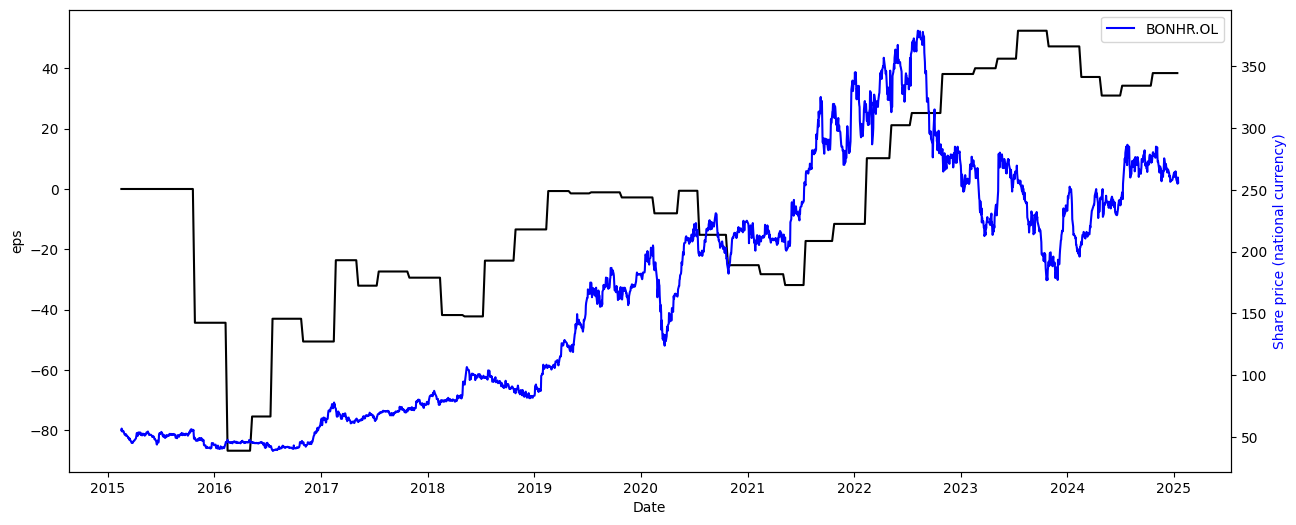

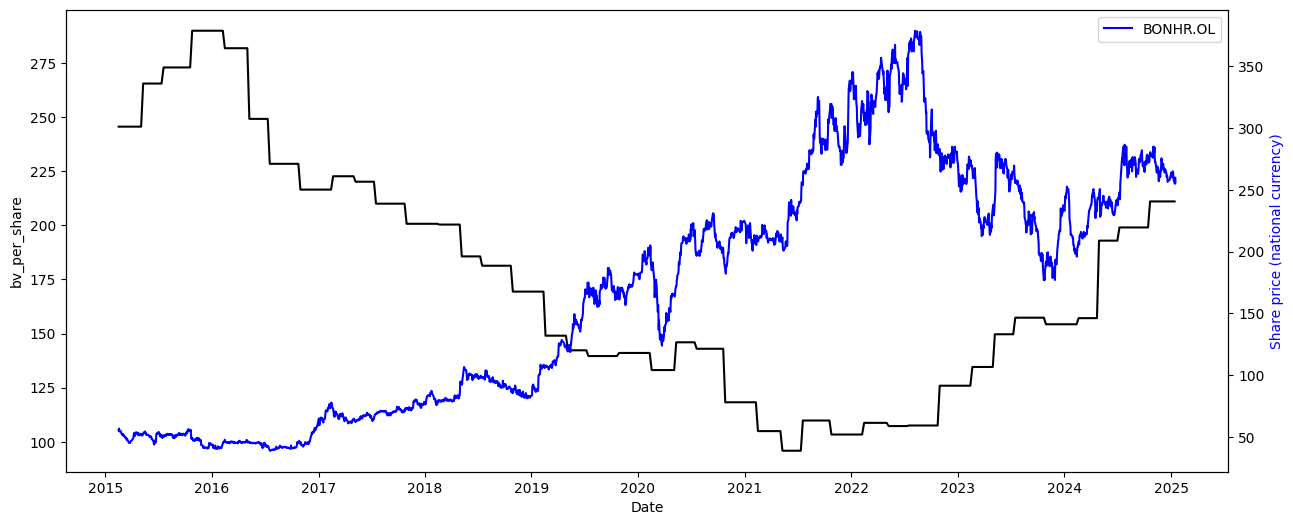

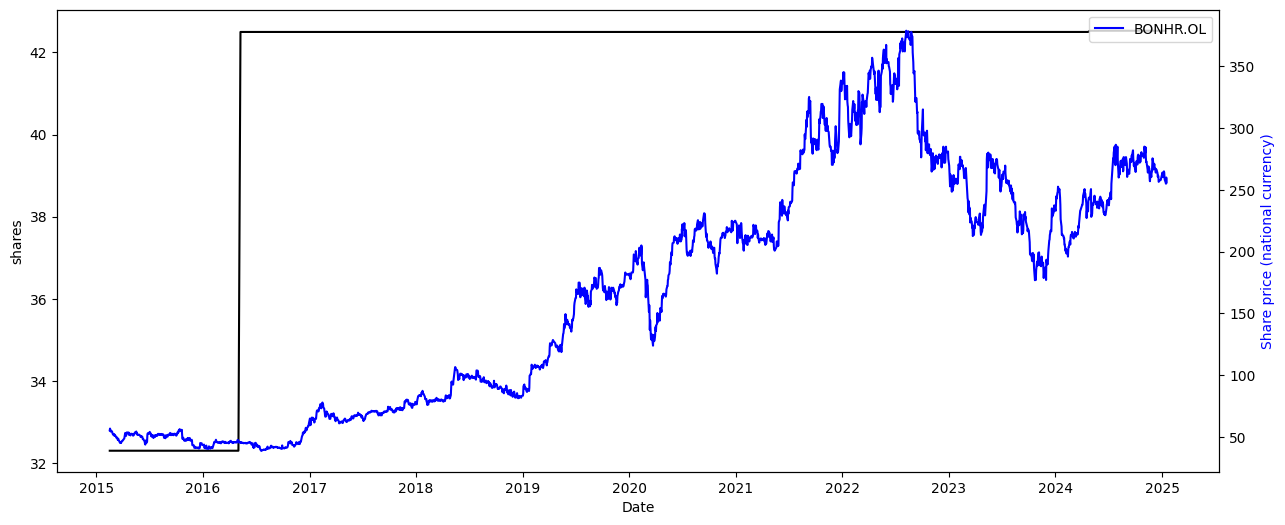

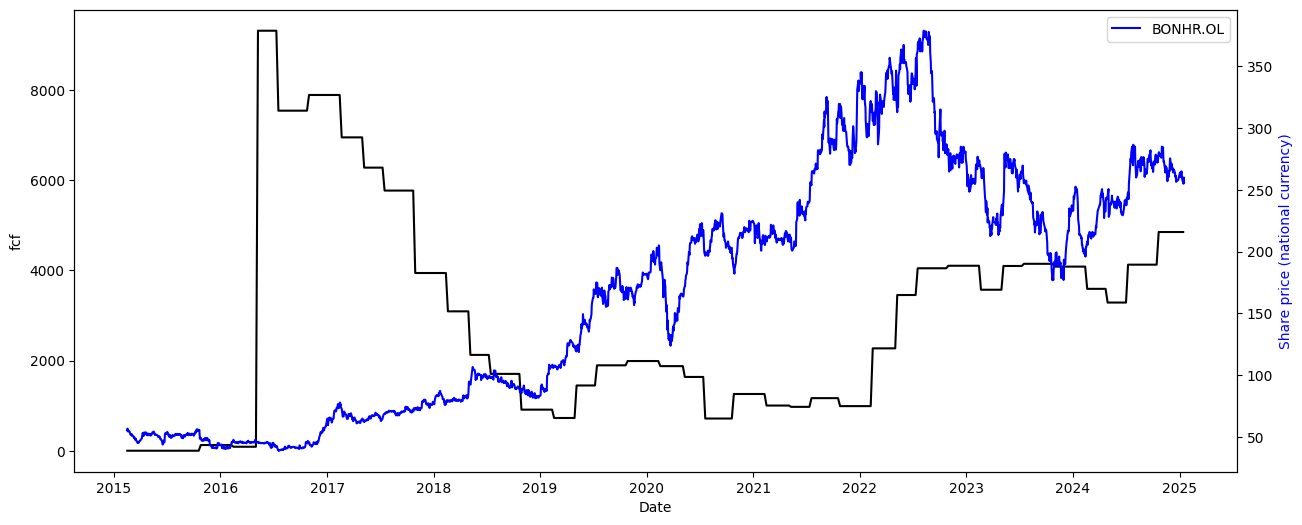

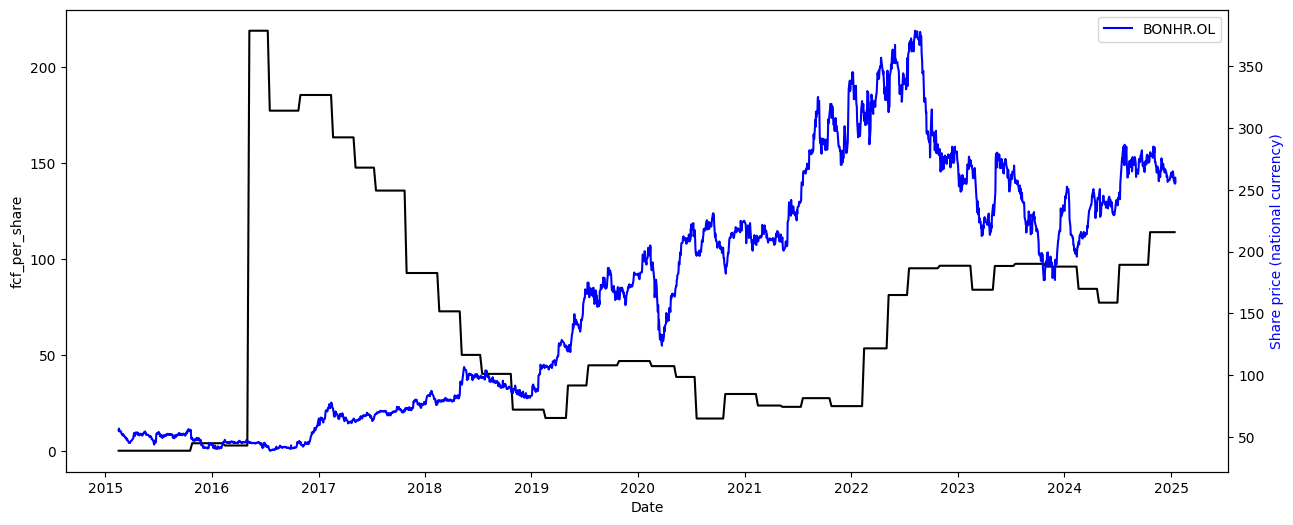

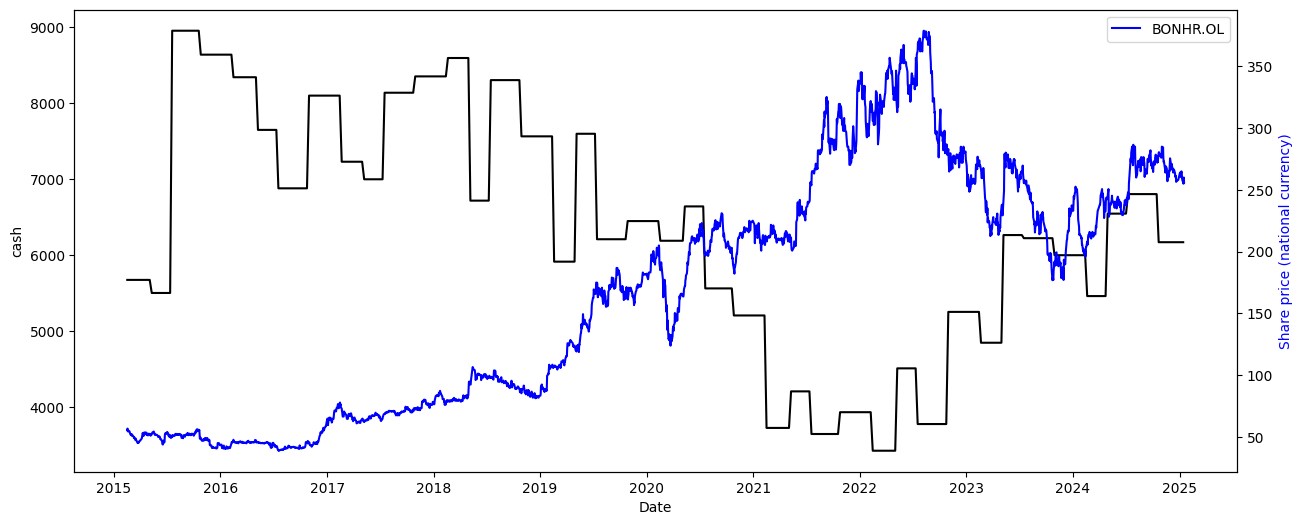

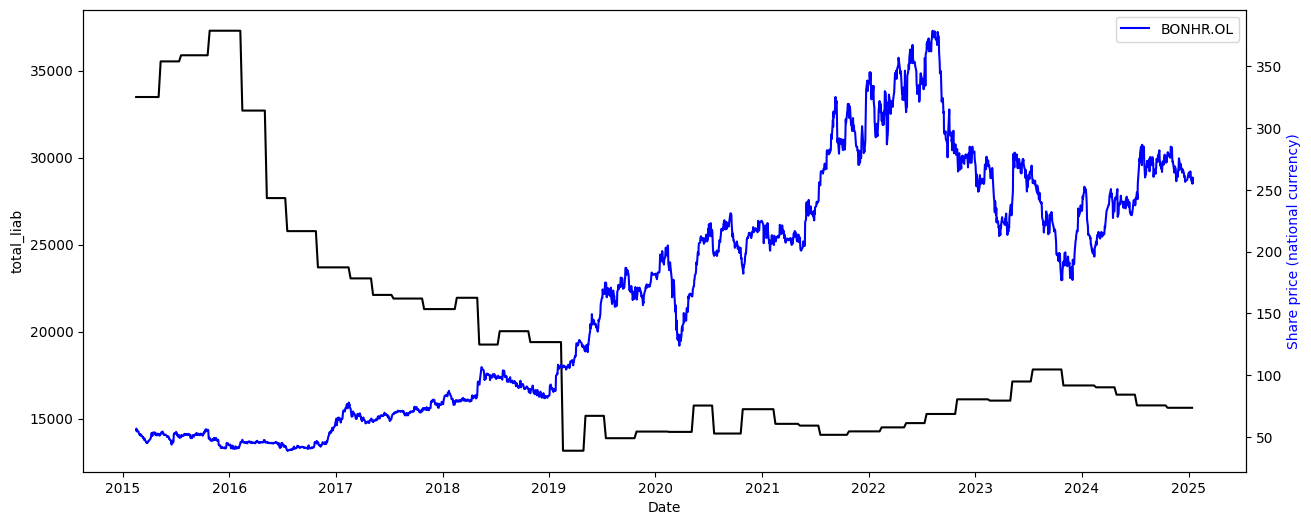

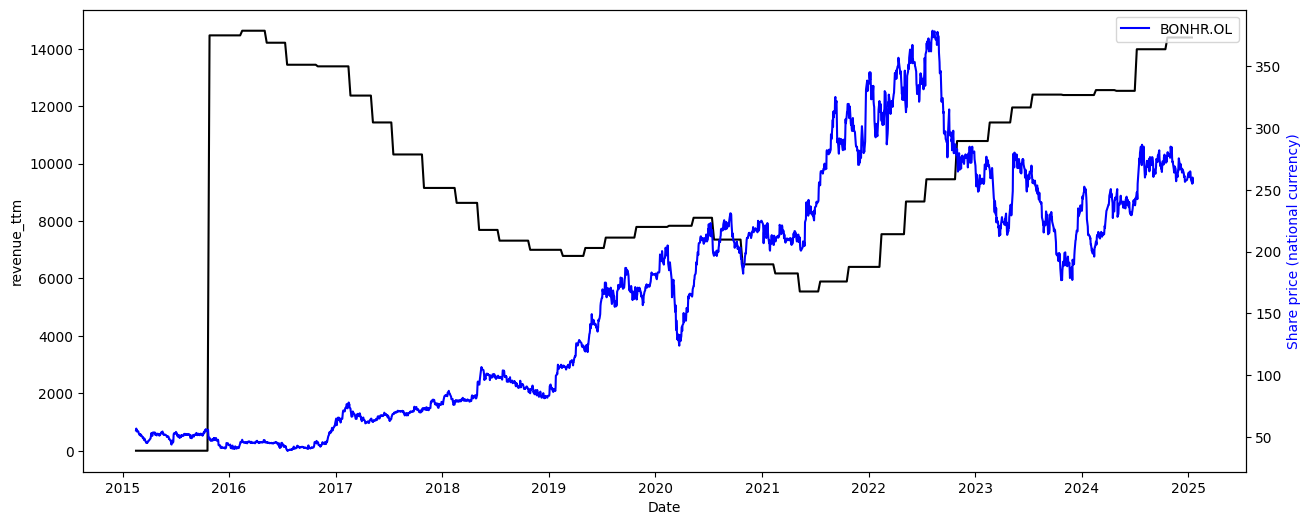

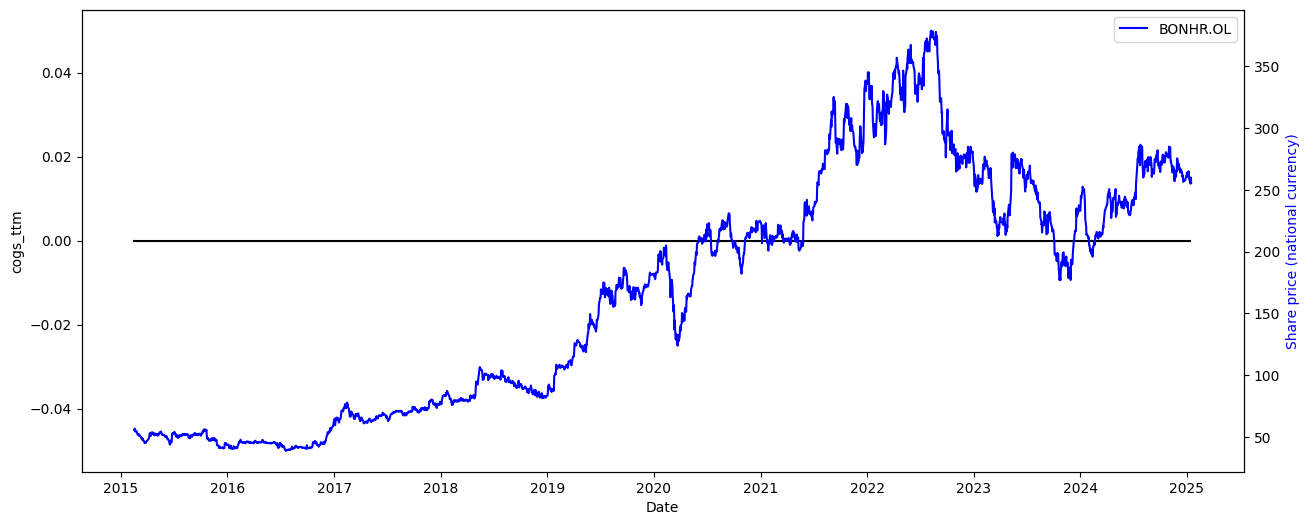

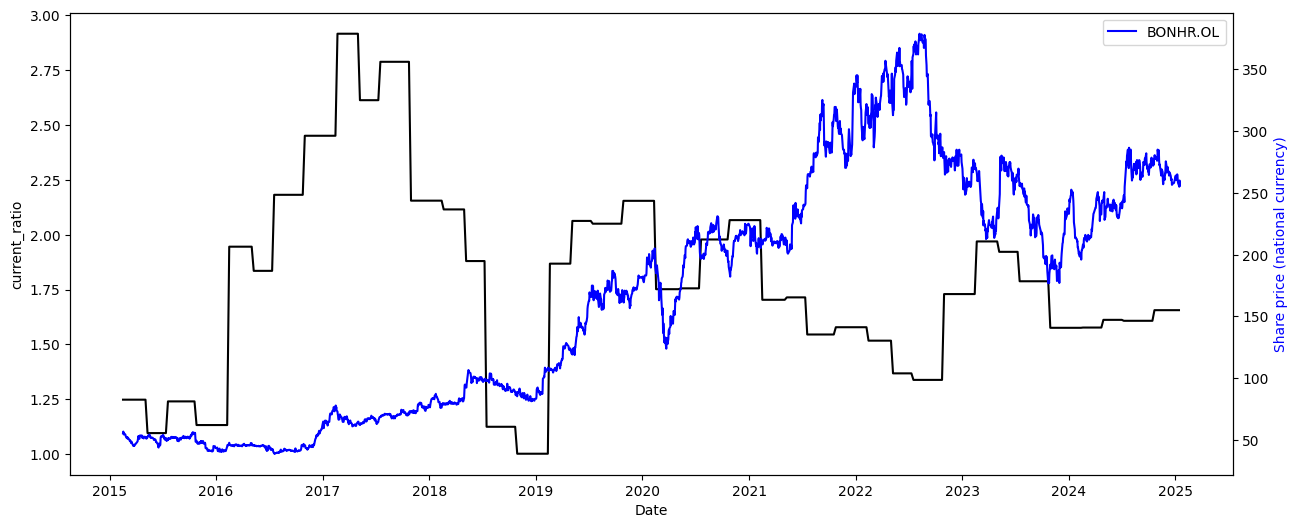

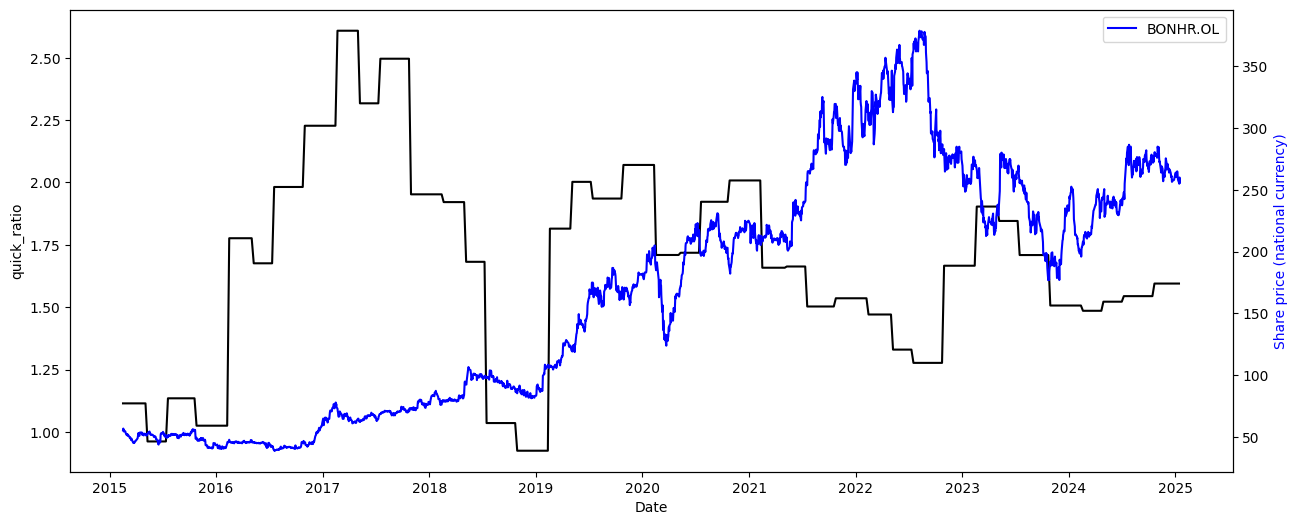

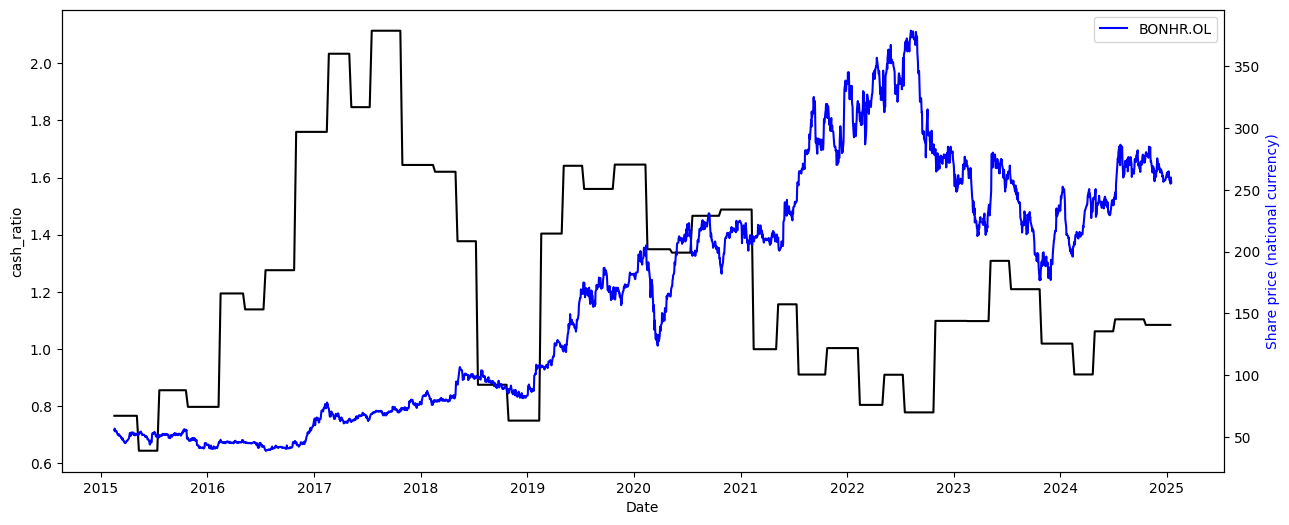

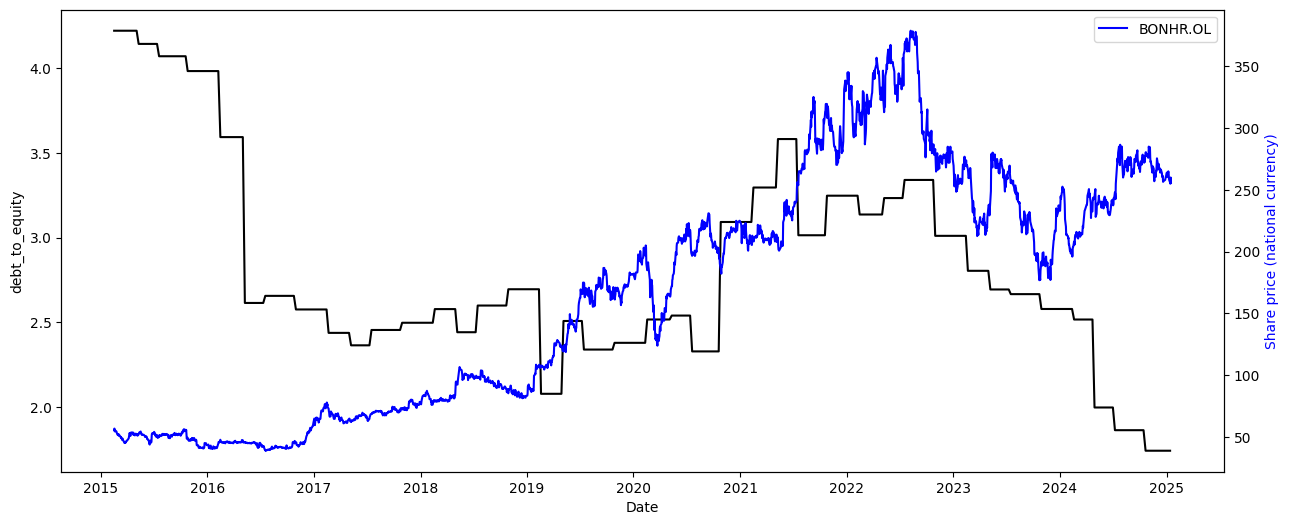

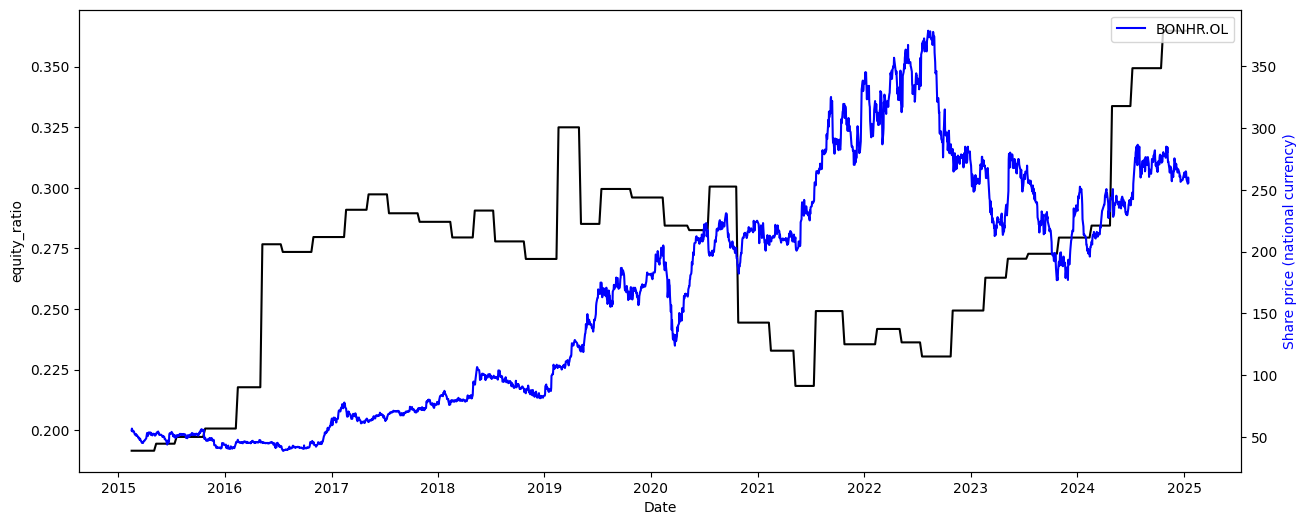

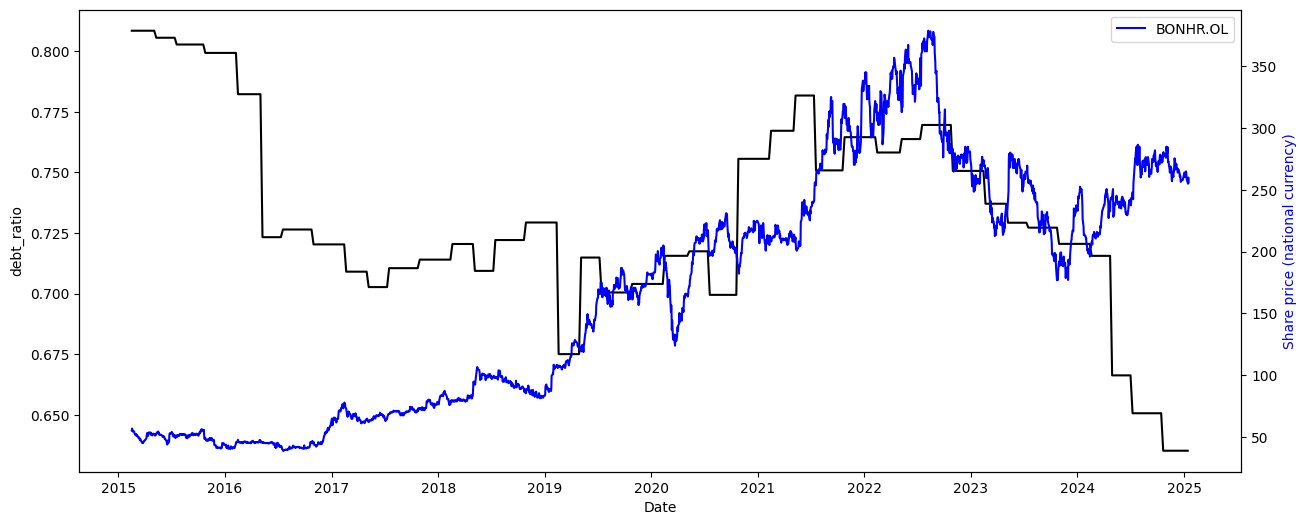

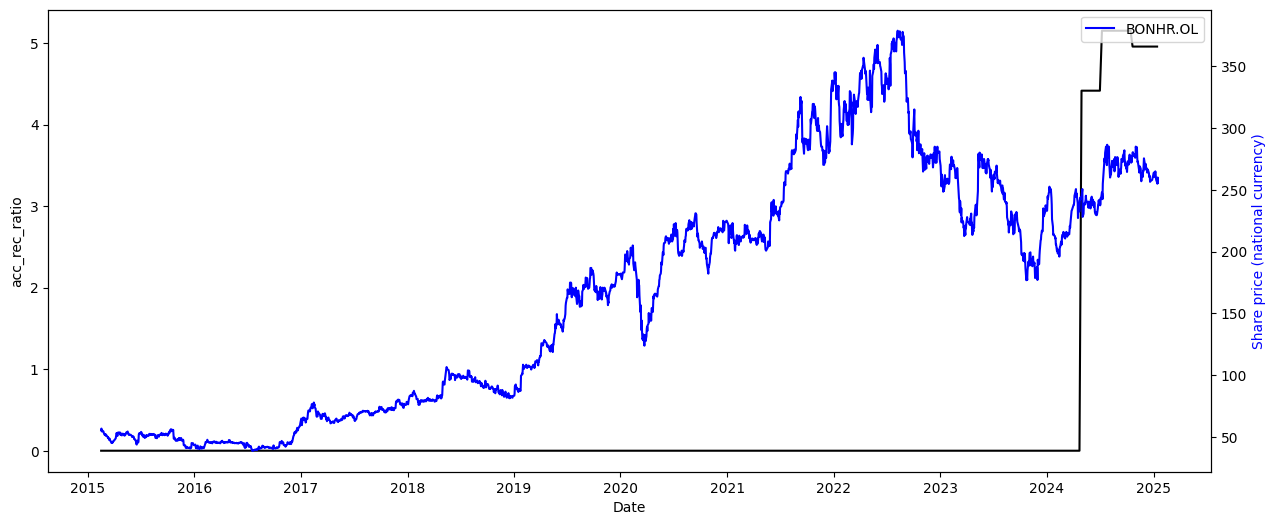

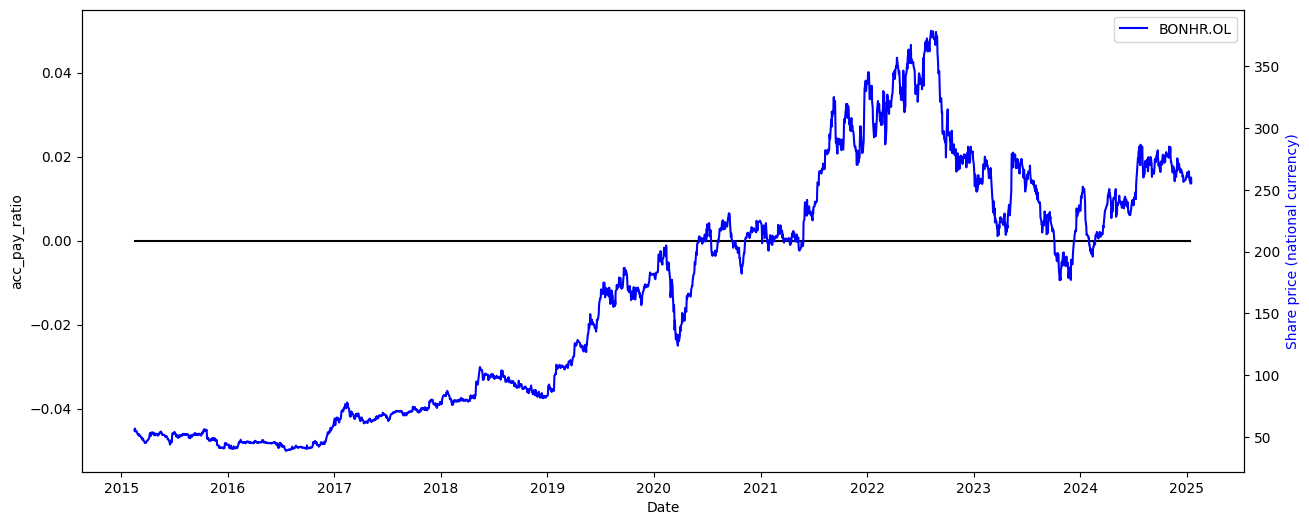

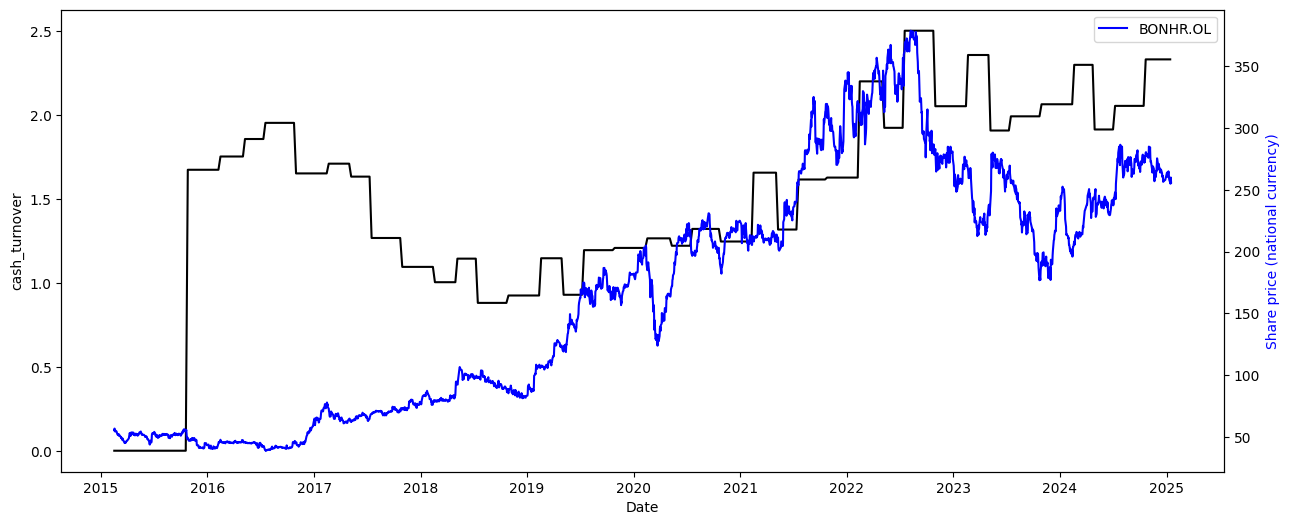

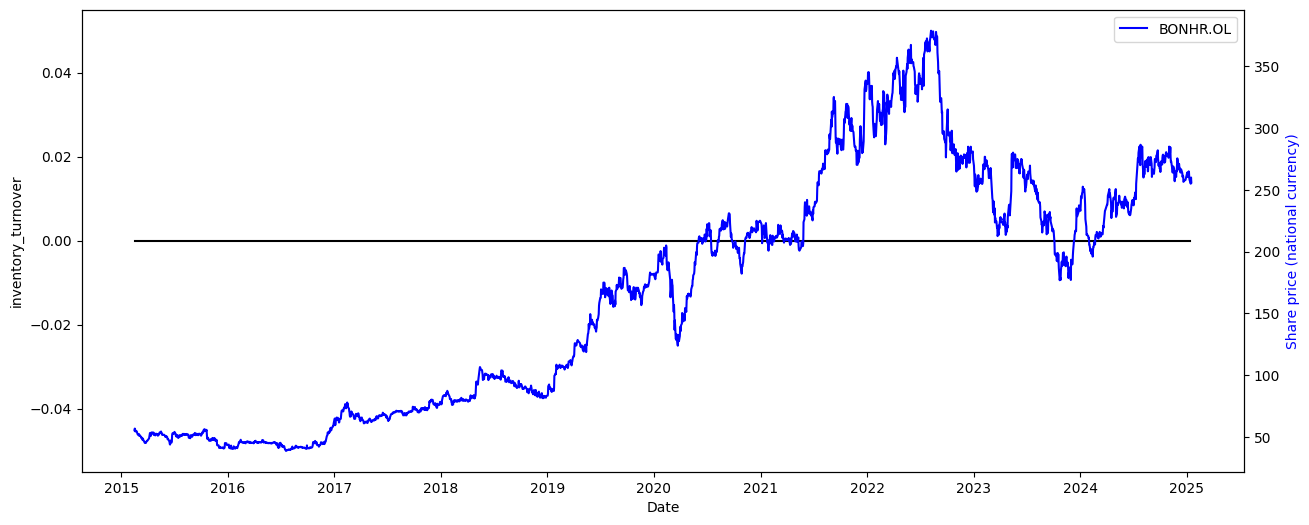

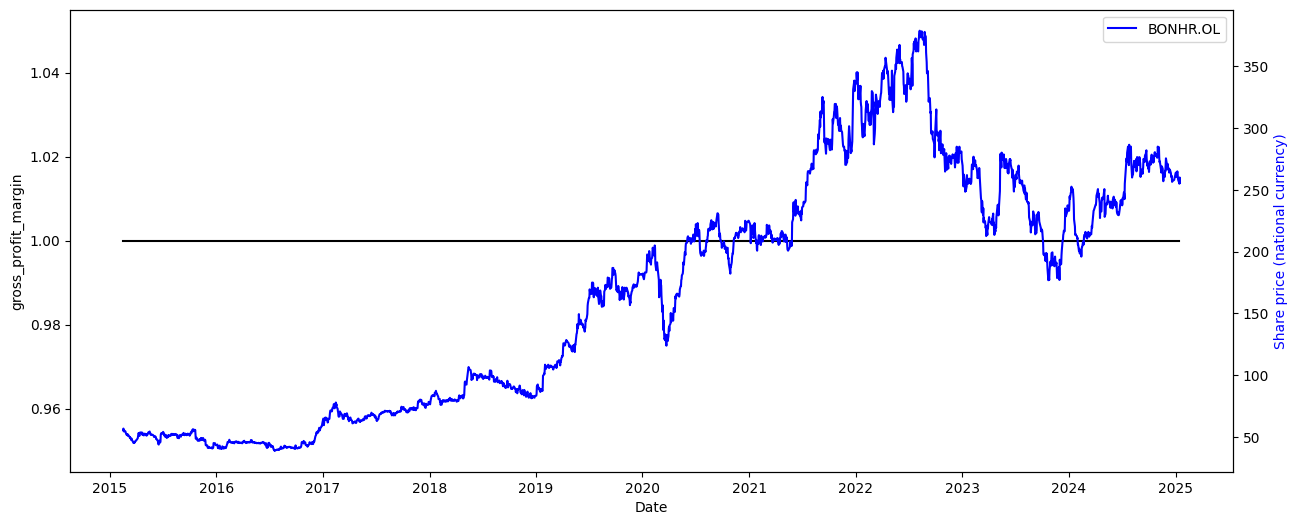

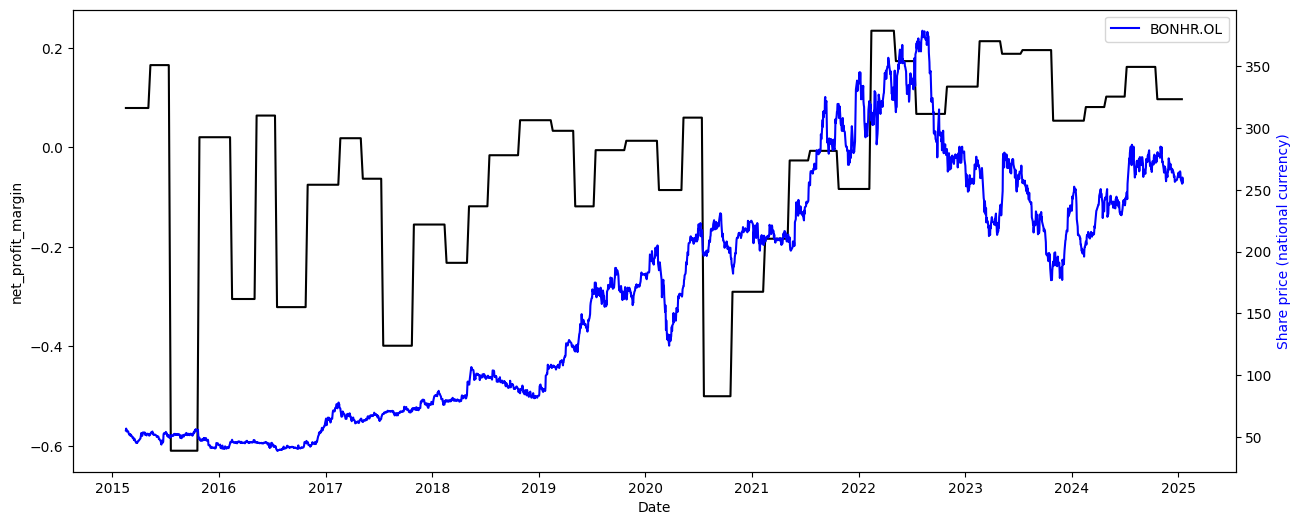

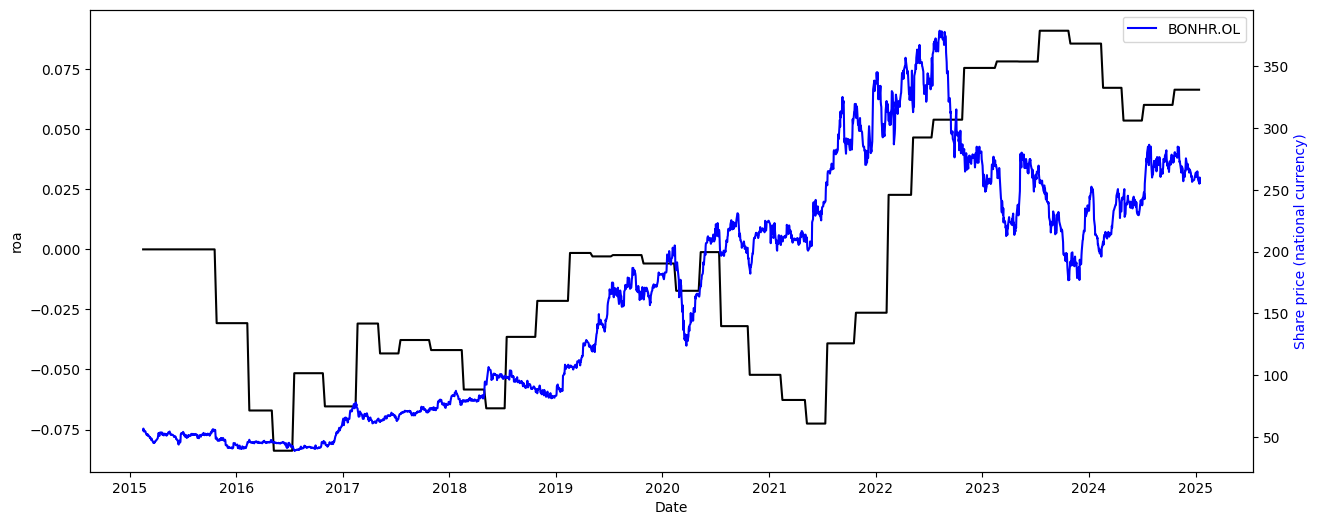

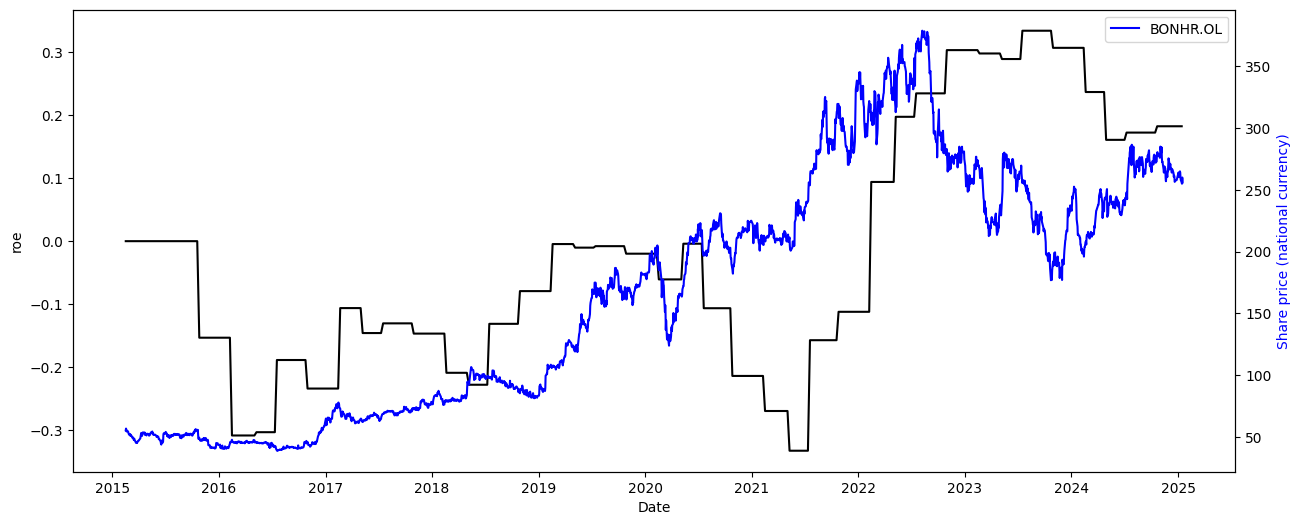

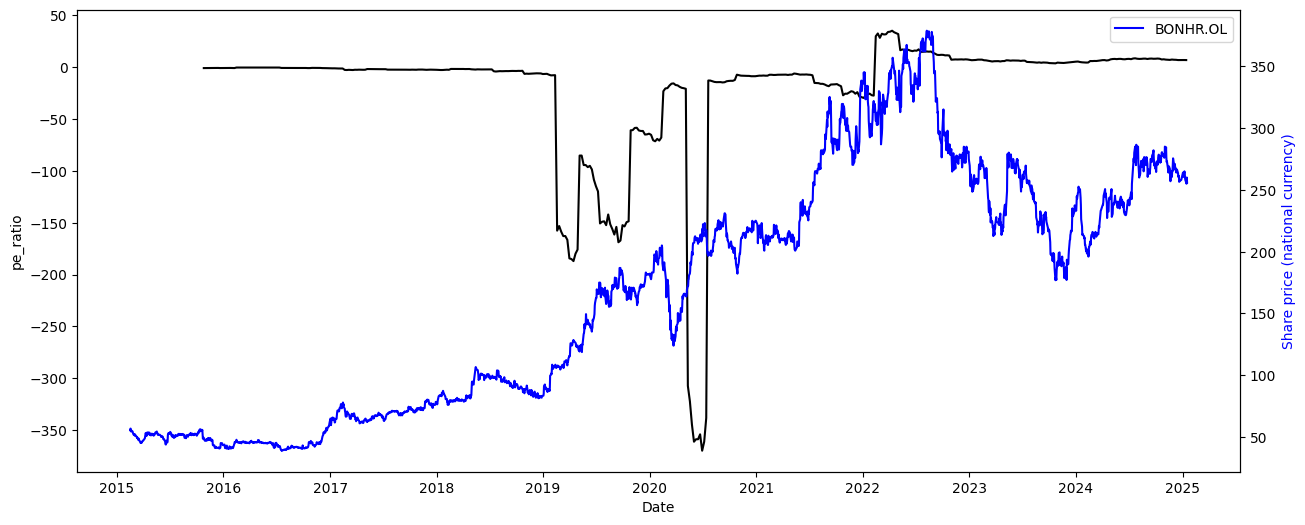

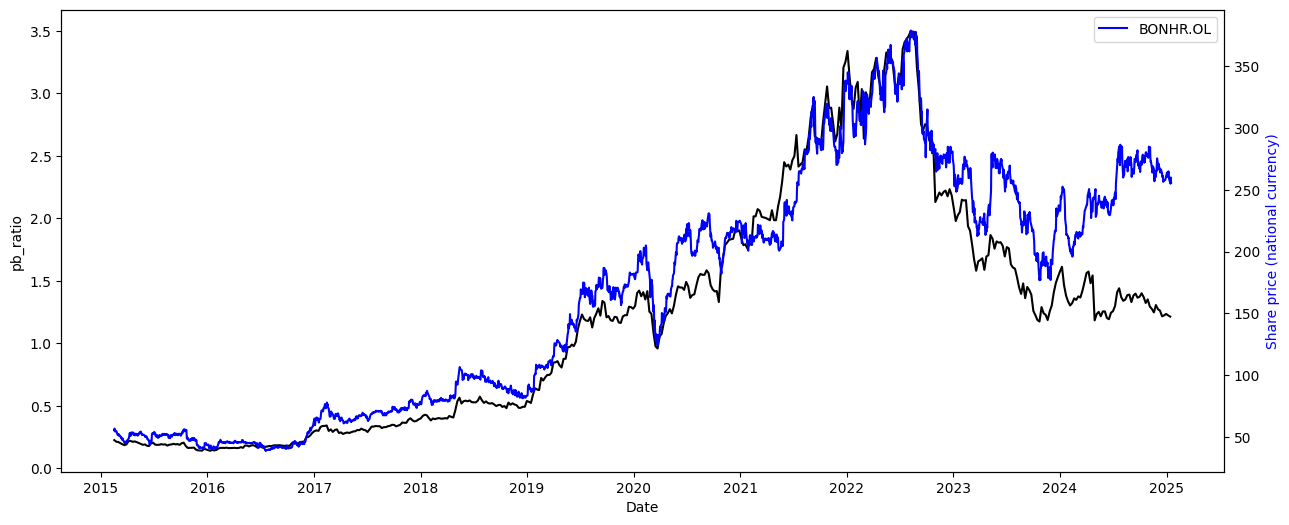

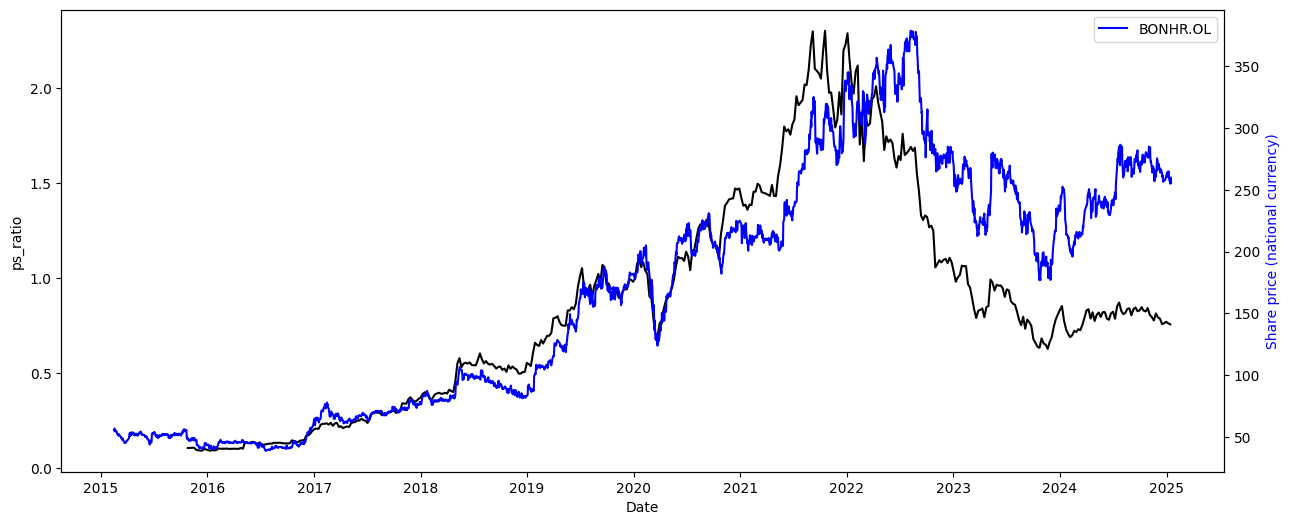

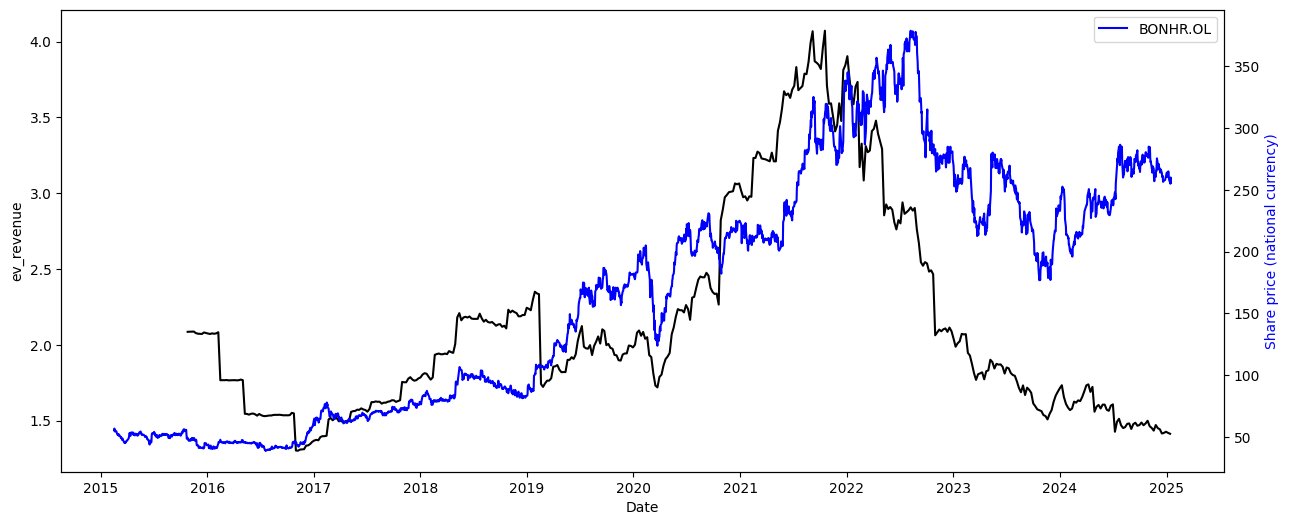

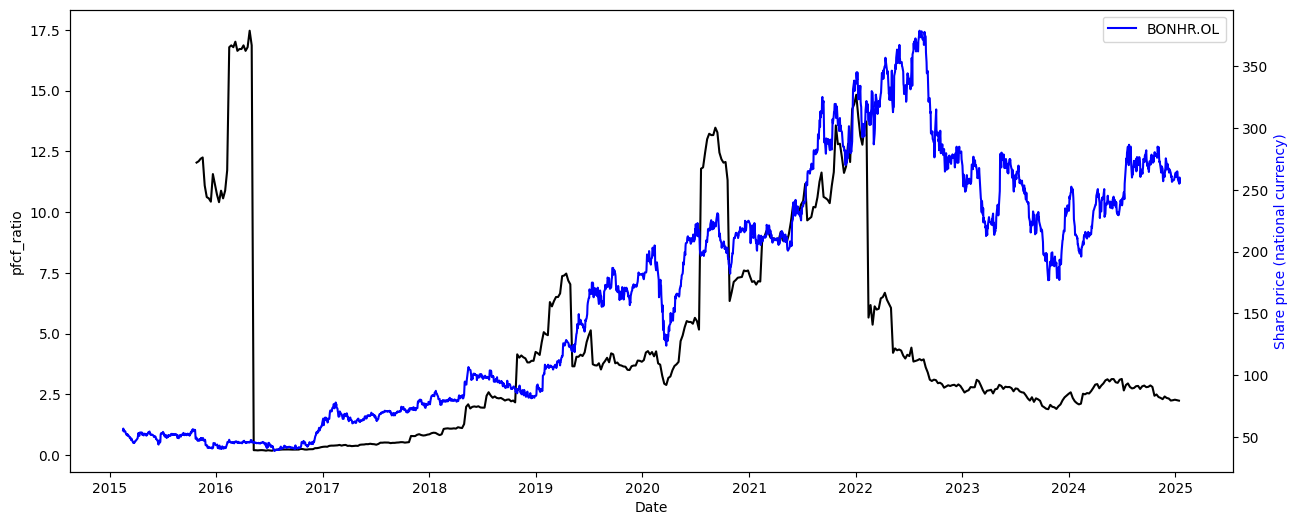

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

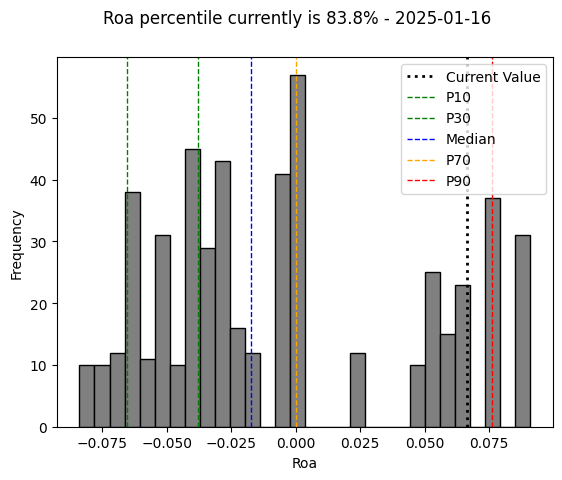

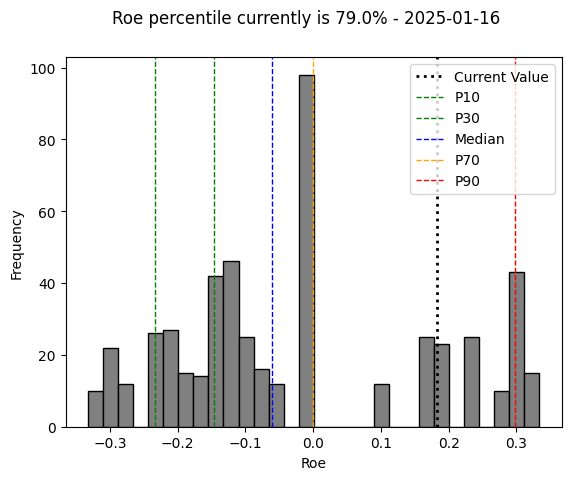

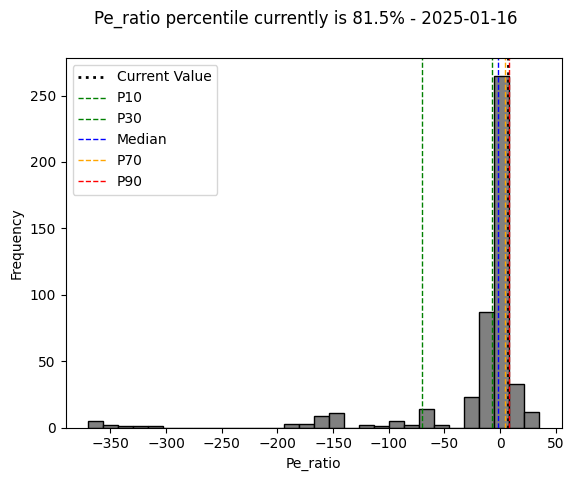

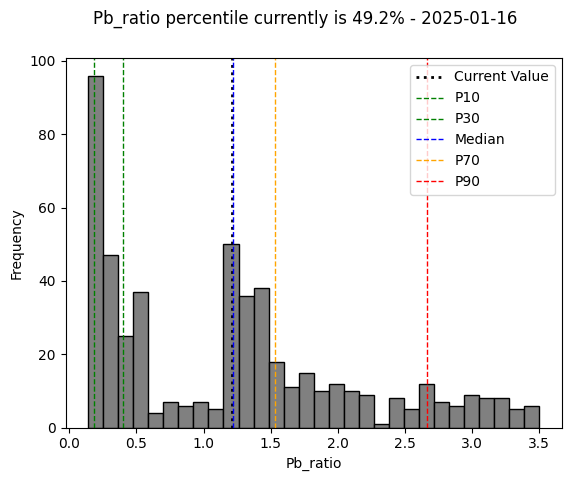

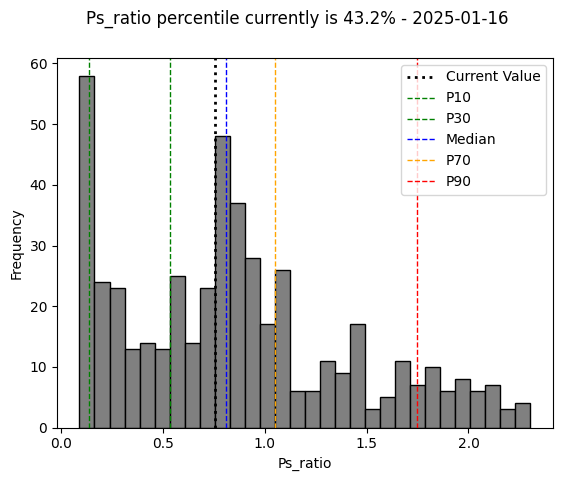

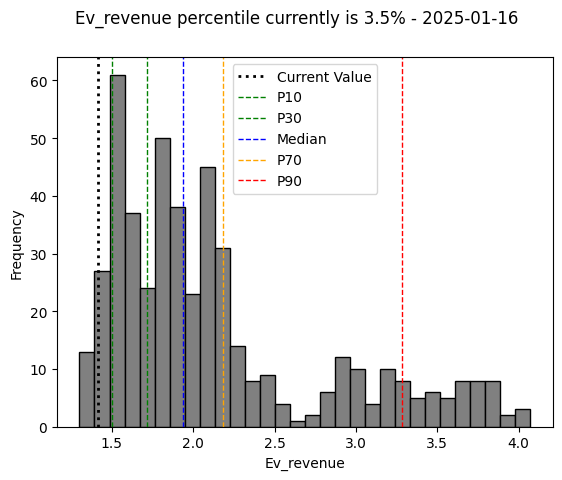

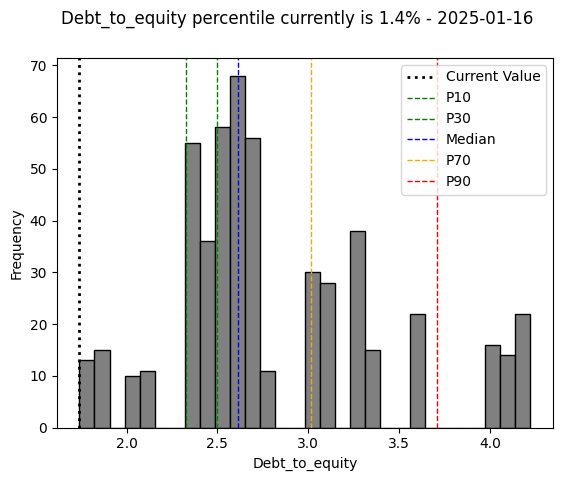

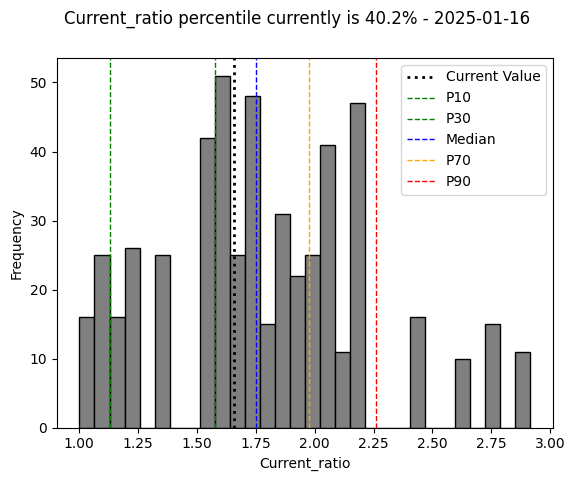

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.992582,0.074598,0.391810,0.201287,-0.212361,-0.164131,-0.285255
roe,0.992582,1.000000,0.065538,0.391030,0.196406,-0.216866,-0.165517,-0.259928
pe_ratio,0.074598,0.065538,1.000000,0.053086,-0.069481,0.007284,0.206832,-0.086545
pb_ratio,0.391810,0.391030,0.053086,1.000000,0.944034,0.739324,0.055829,-0.227612
ps_ratio,0.201287,0.196406,-0.069481,0.944034,1.000000,0.859584,0.271377,-0.344207
ev_revenue,-0.212361,-0.216866,0.007284,0.739324,0.859584,1.000000,0.584284,-0.376192
debt_to_equity,-0.164131,-0.165517,0.206832,0.055829,0.271377,0.584284,1.000000,-0.472464
current_ratio,-0.285255,-0.259928,-0.086545,-0.227612,-0.344207,-0.376192,-0.472464,1.000000


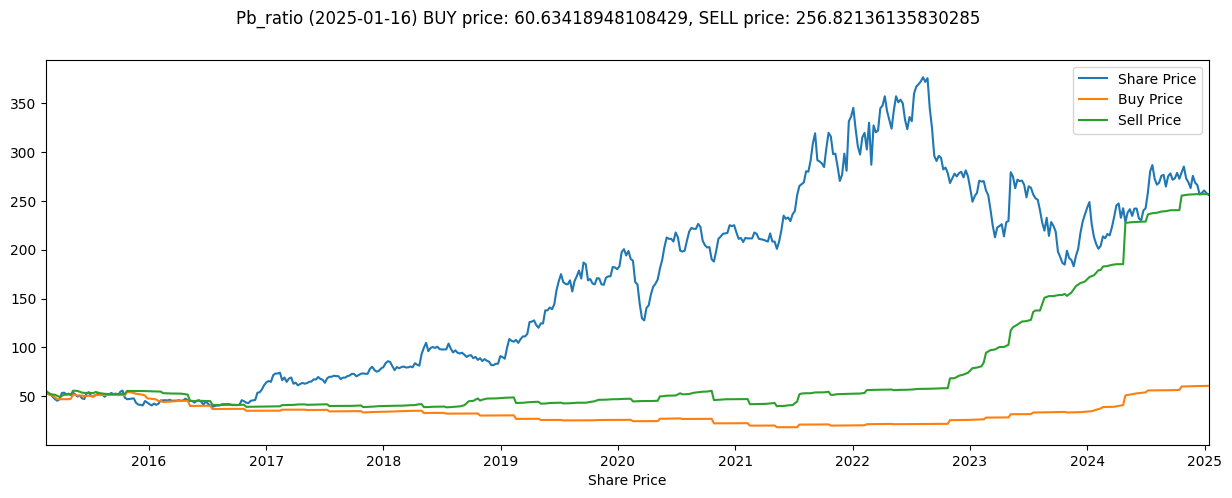

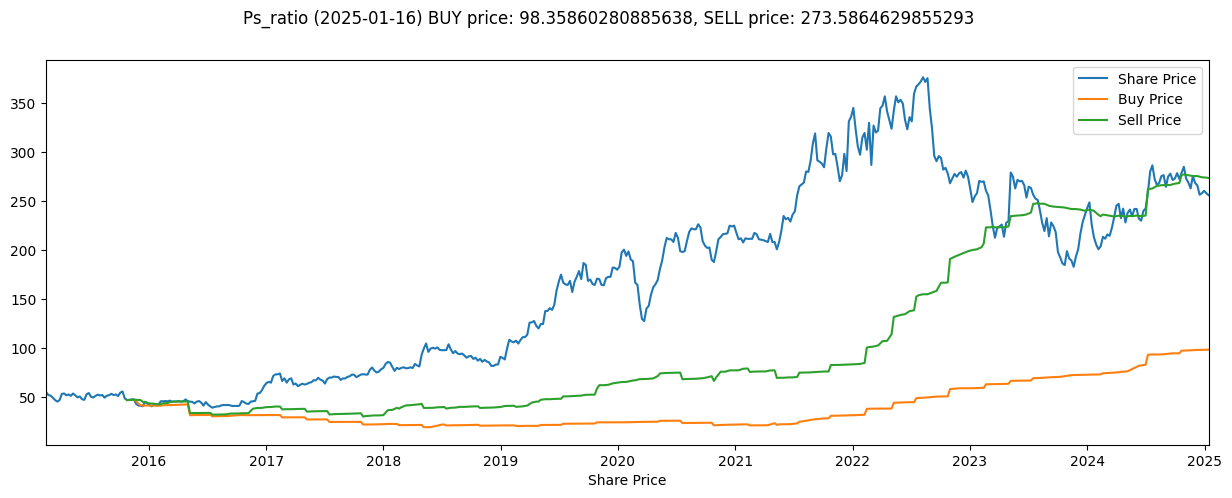

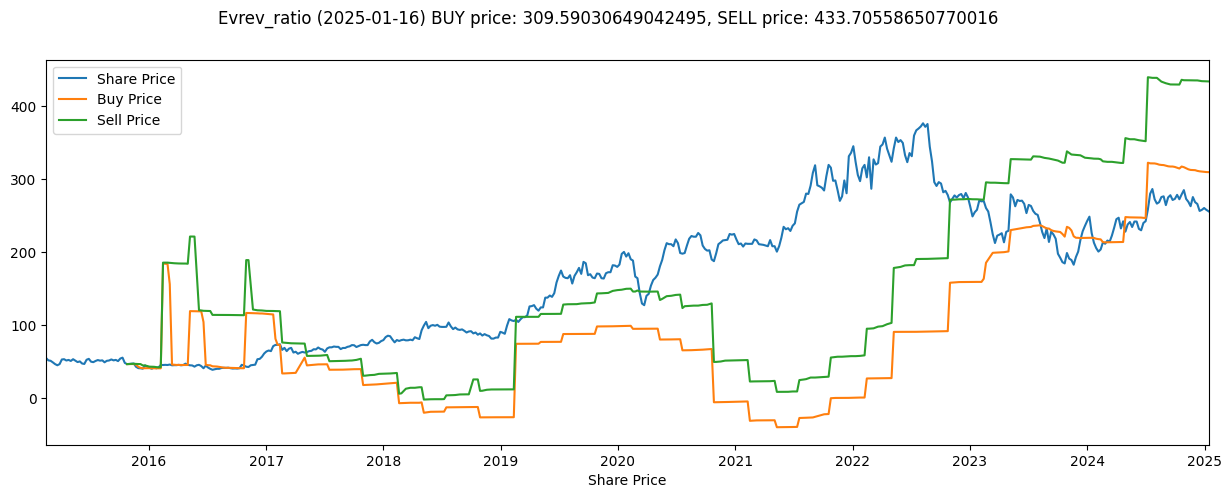

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)